# Fitting a mixture of templates and parametric models

The class `iminuit.cost.Template` supports fitting a mixture of templates and parametric models. This is useful if some components have a simple shape like a Gaussian peak, while other components are complicated and need to be estimated from simulation or a control measurement.

In this notebook, we demonstrate this usage. Our data consists of a Gaussian peak and exponential background. We fit the Gaussian peak with a parametric model and use a template to describe the exponential background.

In [1]:
from iminuit import Minuit
from iminuit.cost import Template
from numba_stats import norm, truncexpon
import numpy as np
from matplotlib import pyplot as plt

We generate the toy data.

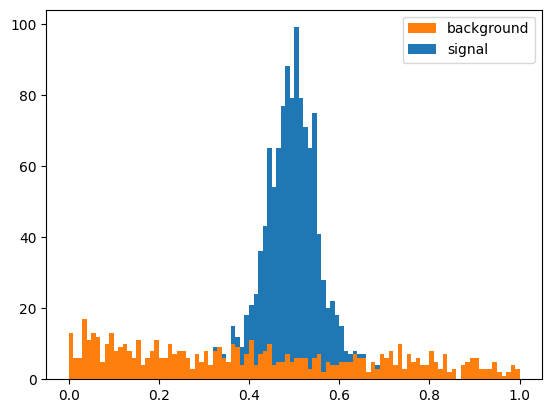

In [2]:
rng = np.random.default_rng(1)

s = rng.normal(0.5, 0.05, size=1000)
b = rng.exponential(1, size=1000)
b = b[b < 1]

ns, xe = np.histogram(s, bins=100, range=(0, 1))
nb, _ = np.histogram(b, bins=xe)
n = ns + nb

plt.stairs(nb, xe, color="C1", fill=True, label="background")
plt.stairs(n, xe, baseline=nb, color="C0", fill=True, label="signal")
plt.legend();

We now model the peaking component parametrically with a Gaussian. A template fit is an extended binned fit, so we need to provide a scaled cumulative density function like for `iminuit.cost.ExtendedBinnedNLL`. To obtain a background template, we generate more samples from the exponential distribution and make a histogram.

In [3]:
# signal model: scaled cdf of a normal distribution
def signal(xe, n, mu, sigma):
    return n * norm.cdf(xe, mu, sigma)

# background template: histogram of MC simulation
rng = np.random.default_rng(2)
b2 = rng.exponential(1, size=1000)
b2 = b2[b2 < 1]
template = np.histogram(b2, bins=xe)[0]

# fit
c = Template(n, xe, (signal, template))
m = Minuit(c, x0_n=500, x0_mu=0.5, x0_sigma=0.05, x1=100)
m.limits["x0_n", "x1", "x0_sigma"] = (0, None)
m.limits["x0_mu"] = (0, 1)
m.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 87.01 (chi2/ndof = 0.9)    │              Nfcn = 194              │
│ EDM = 4.93e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name     │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ x0_n     │    990    │    40     │            │            │    0    │         │       │
│ 1 │ x0_mu    │  0.4951   │  0.0020   │            │            │    0    │    1    │       │
│ 2 │ x0_sigma │  0.0484   │  0.0018   │            │            │    0    │         │       │
│ 3 │ x1       │    630    │    40     │            │            │    0    │         │       │
└───┴──────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬─────────────────────────────────────────┐
│          │      x0_n     x0_mu  x0_sigma        x1 │
├──────────┼─────────────────────────────────────────┤
│     x0_n │  1.43e+03  0.000324    0.0185      -441 │
│    x0_mu │  0.000324  3.87e-06 -5.26e-08 -0.000347 │
│ x0_sigma │    0.0185 -5.26e-08  3.21e-06   -0.0185 │
│       x1 │      -441 -0.000347   -0.0185  1.69e+03 │
└──────────┴─────────────────────────────────────────┘

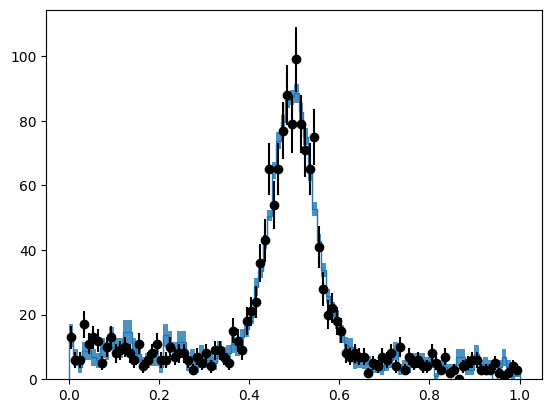

In [4]:
m.visualize()

The fit succeeded and the statistical uncertainty in the template is propagated into the result. You can play with this demo and see what happens if you increase the statistic of the template.

Note: the parameters of a parametric components are prefixed with `xn_` where `n` is the index of the component. This is to avoid name clashes between the parameter names of individual components and for clarity which parameter belongs to which component.